## Random split

In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

# Download the data
from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, opt_tenors, swap_tenors, strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
dataset_split_type = 'temporal_split'
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                   seed=0,
                                                                                   train_ratio=0.8,
                                                                                   type=dataset_split_type)
data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

In [2]:
if dataset_split_type == 'random_split':
    NAME = 'vae_van_leaky_randomsplit_3_200_100_50_25_3000ep_bat16_1e-5'
elif dataset_split_type == 'temporal_split':
    NAME = 'vae_van_leaky_3_128_48_3000ep_bat16_3e-4'

from src.utils.load_model_and_history import load_model_and_history
vae, history = load_model_and_history(NAME,
                                      data_type='vol')

c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
import numpy as np

points_num = len(data_test[0].reshape(-1))

# Generate N vol cubes
N = 10_000
latent_space_dim = vae.latent_space_dim
mean = np.zeros(latent_space_dim)
cov = np.eye(latent_space_dim)
np.random.seed(0)
z_initial = np.random.multivariate_normal(mean, cov, N)
gen_vol_cubes = normalizer.denormalize(vae.decoder.predict(np.array(z_initial), verbose=0))

In [4]:
def skewness(data):
    mean_val = data.mean()
    stdev = data.std()
    return ((data - mean_val)**3).mean() / stdev**3

def kurtosis(data):
    mean_val = data.mean()
    stdev = data.std()
    return ((data - mean_val)**4).mean() / stdev**4

print(data_train.mean(), gen_vol_cubes.mean())
print(data_train.std(), gen_vol_cubes.std())
print(skewness(data_train), skewness(gen_vol_cubes))
print(kurtosis(data_train), kurtosis(gen_vol_cubes))

33.56189692832764 33.31631
15.431941345821224 15.12408
2.5956743318147466 2.7404834809103793
15.051017384130564 16.72961579710211


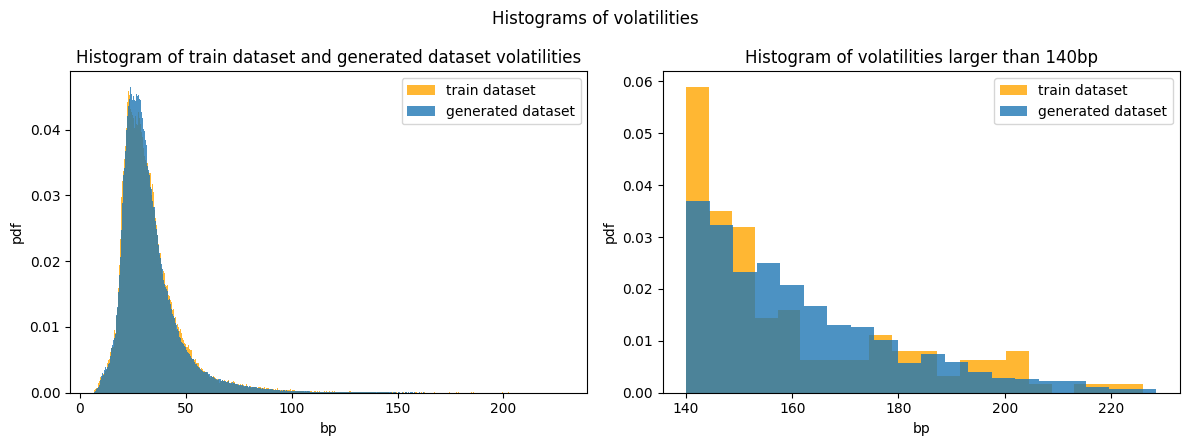

In [5]:
from src.visualization.vol.hist_comparison import hist_comparison
hist_comparison(data1=data_train,
                data1_label='train dataset',
                data2=gen_vol_cubes,
                data2_label='generated dataset',
                alpha=0.8,
                bins_all=500,
                threshold=140,
                bins_higher_th=20
                )

## Heatmap

In [6]:
import seaborn as sns
import pandas as pd

df_train = pd.DataFrame(data=data_train.reshape((data_train.shape[0], -1)))
df_test = pd.DataFrame(data=data_test.reshape((data_test.shape[0], -1)))
df_gen = pd.DataFrame(data=gen_vol_cubes.reshape((gen_vol_cubes.shape[0], -1)))

0.023792106712225453


<Axes: >

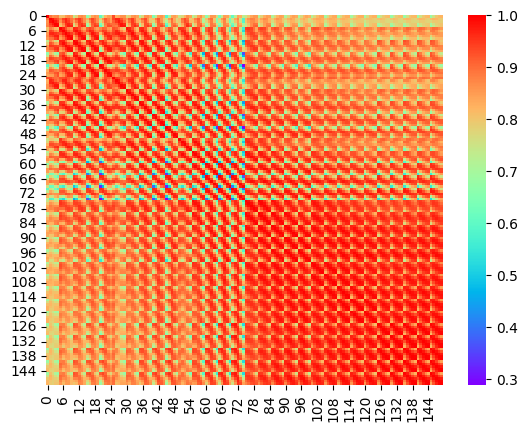

In [7]:
print(abs(df_gen.corr() - df_train.corr()).mean().mean())
sns.heatmap(df_train.corr(), cmap='rainbow')

0.023792106712225453


<Axes: >

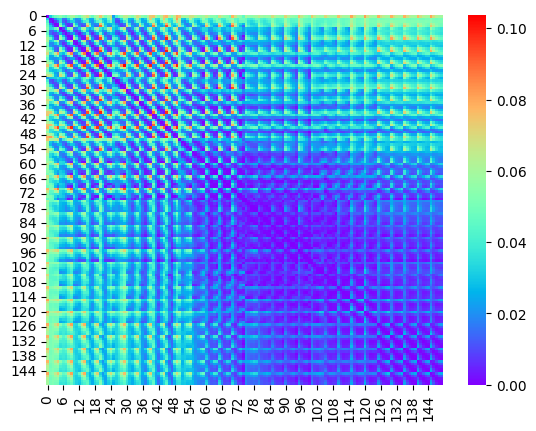

In [8]:
print(abs(df_gen.corr() - df_train.corr()).mean().mean())
sns.heatmap(abs(df_gen.corr() - df_train.corr()), cmap='rainbow')

In [9]:
# KS_test
max_val =float('-inf')

from scipy import stats
for ot, _ in enumerate(opt_tenors):
    for st, _ in enumerate(swap_tenors):
        for s, _ in enumerate(strikes):
            ks_test = stats.ks_2samp(data_train[:, ot,st,s], gen_vol_cubes[:,ot,st,s])[0]
            if ks_test > max_val:
                max_val = ks_test
                ot_, st_, s_ = ot, st, s
max_val, ot_,st_,s_

(0.09734971558589306, 2, 4, 4)

In [10]:
stats.ks_2samp(data_train[:, ot_,st_,s_], gen_vol_cubes[:,ot_,st_,s_])

KstestResult(statistic=0.09734971558589306, pvalue=4.0598333949409923e-07, statistic_location=20.5, statistic_sign=1)

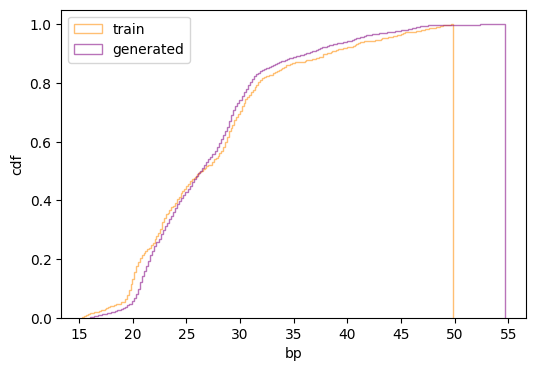

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(data_train[:, ot_,st_,s_], bins=200, density=True, cumulative=True, label='train', 
         histtype='step', alpha=0.55, color='darkorange')
plt.hist(gen_vol_cubes[:, ot_,st_,s_], bins=200, density=True, cumulative=True, label='generated', 
         histtype='step', alpha=0.55, color='purple')
plt.xlabel('bp')
plt.ylabel('cdf')
plt.legend()
plt.show()

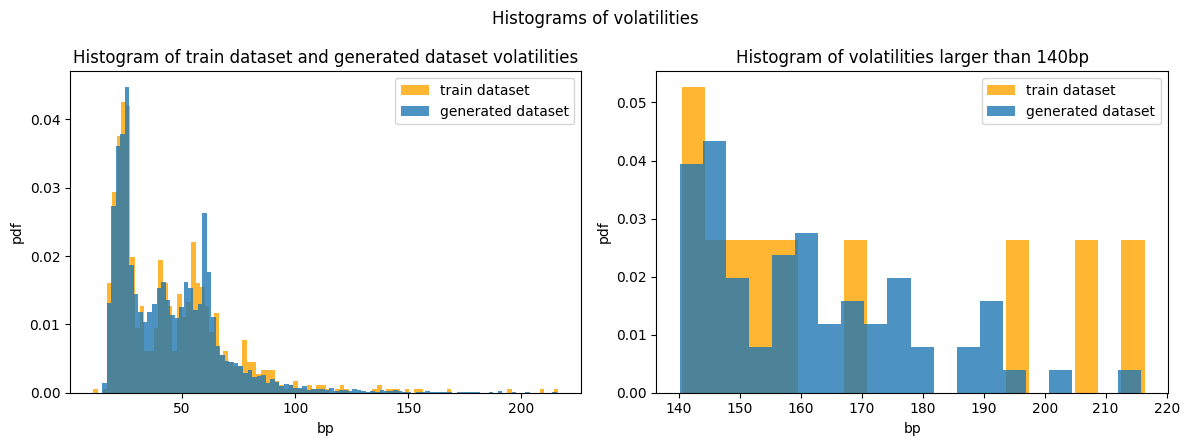

In [12]:
from src.visualization.vol.hist_comparison import hist_comparison
hist_comparison(data1=data_train[:,0,0,0],
                data1_label='train dataset',
                data2=gen_vol_cubes[:,0,0,0],
                data2_label='generated dataset',
                alpha=0.8,
                bins_all=100,
                threshold=140,
                bins_higher_th=20
                )